In [1]:
from enum import Enum
from itertools import product
from typing import Tuple, List, NewType
from string import Template

Suite = Enum("Suites", ["Clubs", "Diamonds", "Spades", "Hearts"])
Rank = Enum("Ranks", ["Ace", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine", "Ten", "Jack", "Queen", "King"])
DistributionStrategy = Enum("DistributionStrategy", ["Uniformly"])

Card = NewType("Card", Tuple[Suite, Rank])
Deck = NewType("Deck", List[Card])

STANDARD_DECK: Deck = list(product(list(Suite), list(Rank)))

def distribute_cards_uniformly(deck: Deck, num_players: int) -> List[Deck]:
    """
    Distribute the given deck of cards amongst num_players

    Args:
        deck: The deck of cards.
        num_players: The number of players in the game.
    
    Returns:
        A list of deck of cards for each player.
    
    Raises:
        ValueError: When an even distribution is not possible.
    """
    
    if len(deck) % num_players != 0:
        raise ValueError(
            Template("Cannot evenly distribute $num_cards amongst $num_players").substitute(num_cards = len(deck), num_players = num_players)
        )
    player_cards = [[] for _ in range(num_players)]
    for idx, card in enumerate(deck):
        player_cards[idx % num_players].append(card)
    return player_cards

def distribute_cards(deck: Deck, num_players: int, distribution_strategy: DistributionStrategy) -> List[Deck]:
    """
    Distribute a deck of cards to the players using a distribution strategy.
    
    Args:
        deck: The deck of cards.
        num_players: The number of players in the game.
        distribution_strategy: The strategy used to distribute the cards.
    
    Returns:
        A list of deck of cards for each player.
    """
    
    match distribution_strategy:
        case DistributionStrategy.Uniformly:
            return distribute_cards_uniformly(deck, num_players)
        case _:
            raise ValueError("Unknown distribution strategy.")

In [2]:
from random import shuffle
from copy import deepcopy

def simulate(num_players):
    """
    Simulates the game of bhikar_savkar for a given number of players.
    Args:
        num_players: The number of players in the game.
    """

    # Game setup. Use a standard shuffled deck. Distribute it evenly among players.
    deck = deepcopy(STANDARD_DECK)
    shuffle(deck)
    # Removing extra cards for equal distribution. Does it matter in this game ? :p
    deck = deck[: len(deck) - (len(deck) % num_players)]
    player_cards = distribute_cards(deck, num_players, DistributionStrategy.Uniformly)
    acquired_cards = [[] for _ in range(num_players)]
    current_pile = []
    eliminated_players = []
    current_player = 0
    turns = 0
    
    # Playing the game until all but one players are elimintated.
    while len(eliminated_players) != num_players - 1:
        # If you are eliminated, give turn to next player.
        if current_player in eliminated_players:
            current_player = (current_player + 1) % num_players
            continue
        # Play a card into the current pile
        current_pile.append(player_cards[current_player].pop())
        turns += 1
        if len(current_pile) > 1:
            # Got matching card. Take everything in the current pile
            if current_pile[-1][0] == current_pile[-2][0]:
                acquired_cards[current_player] += current_pile
                current_pile = []
        # Ran out of cards
        if len(player_cards[current_player]) == 0:
            # Acquired some cards ? Use them now.
            if len(acquired_cards[current_player]) > 0:
                shuffle(acquired_cards[current_player])
                player_cards[current_player] = acquired_cards[current_player]
                acquired_cards[current_player] = []
            else:
                eliminated_players.append(current_player)
        # Next player's turn.
        current_player = (current_player + 1) % num_players
    return turns

In [59]:
from statistics import mean, stdev

# Simulating the game
players = range(2, 10)
num_simulations = 100000

data = {}
for num_players in players:
    turns = []
    for _ in range(num_simulations):
        turns.append(simulate(num_players))
    print(
        Template(
        "Finished simulation for $num_players players.")
          .substitute(num_players=num_players
        )
    )
    print(
        Template(
        "Turns to finish the game stats: min=$min max=$max mean=$mean, std_dev=$std_dev")
          .substitute(min=min(turns), max=max(turns), mean=mean(turns), std_dev=stdev(turns)
        )
    )
    data[num_players] = turns

Finished simulation for 2 players.
Turns to finish the game stats: min=51 max=2543 mean=273.73055, std_dev=210.24756171492115
Finished simulation for 3 players.
Turns to finish the game stats: min=50 max=2811 mean=323.42167, std_dev=212.32292239568682
Finished simulation for 4 players.
Turns to finish the game stats: min=51 max=2861 mean=364.53717, std_dev=225.7996223050106
Finished simulation for 5 players.
Turns to finish the game stats: min=49 max=2369 mean=351.18718, std_dev=208.5212902677627
Finished simulation for 6 players.
Turns to finish the game stats: min=47 max=2186 mean=329.90962, std_dev=190.63189580091932
Finished simulation for 7 players.
Turns to finish the game stats: min=48 max=2282 mean=351.46101, std_dev=200.60657304722446
Finished simulation for 8 players.
Turns to finish the game stats: min=47 max=2300 mean=341.30457, std_dev=192.49394490815382
Finished simulation for 9 players.
Turns to finish the game stats: min=44 max=1889 mean=298.68489, std_dev=165.345582424

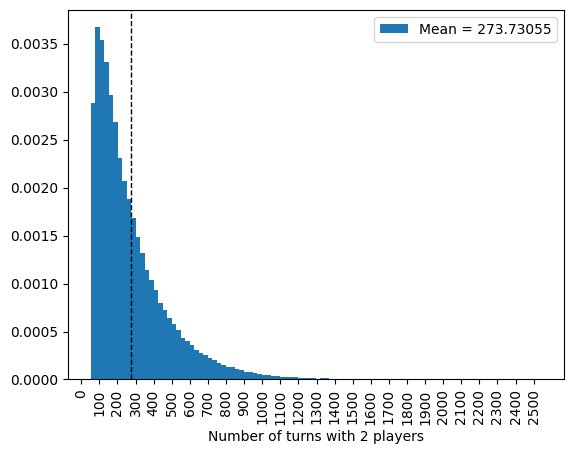

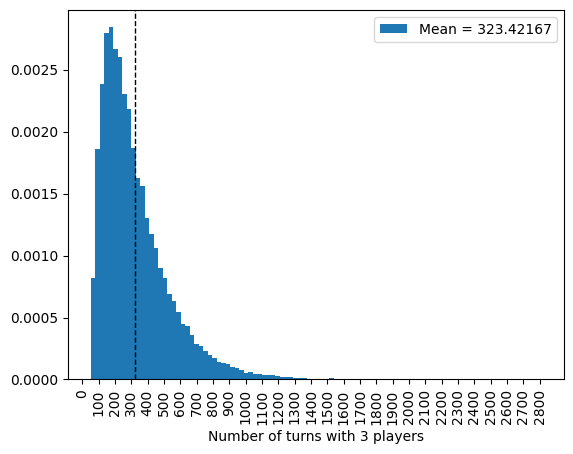

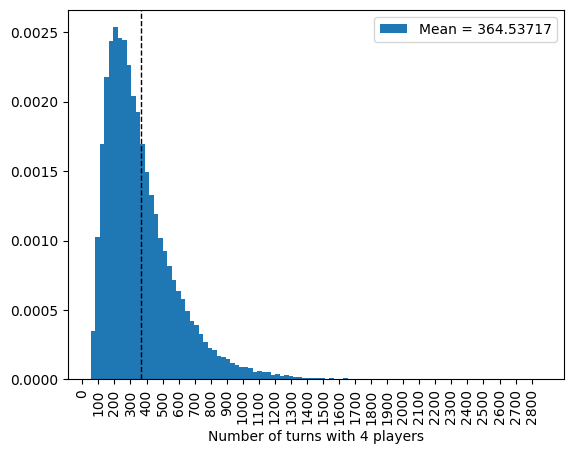

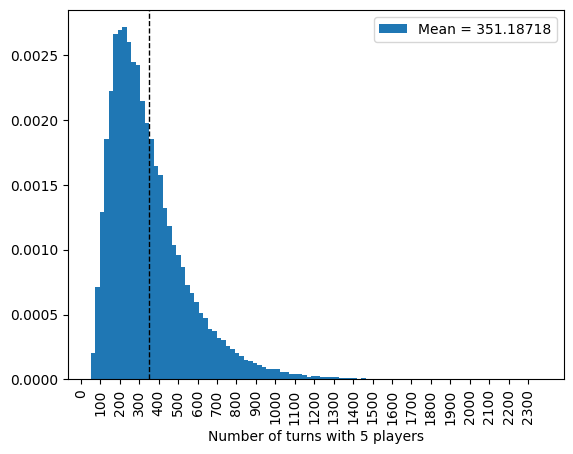

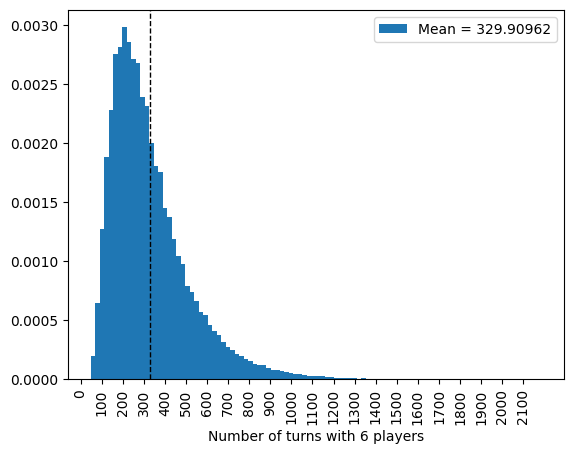

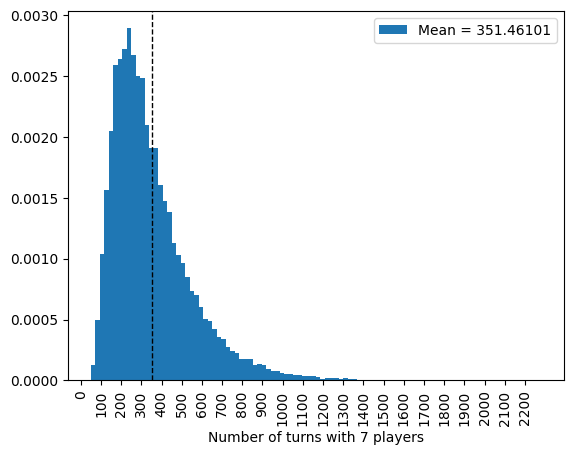

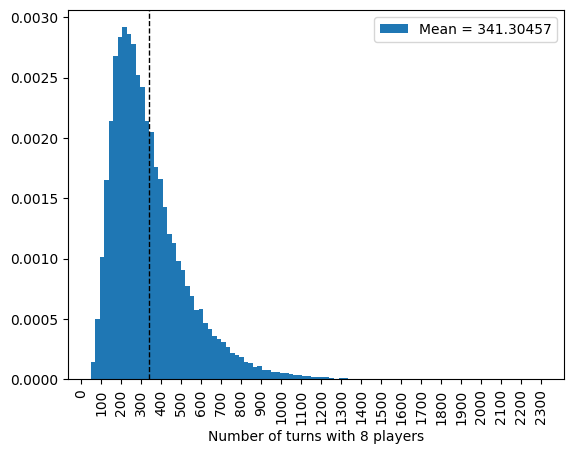

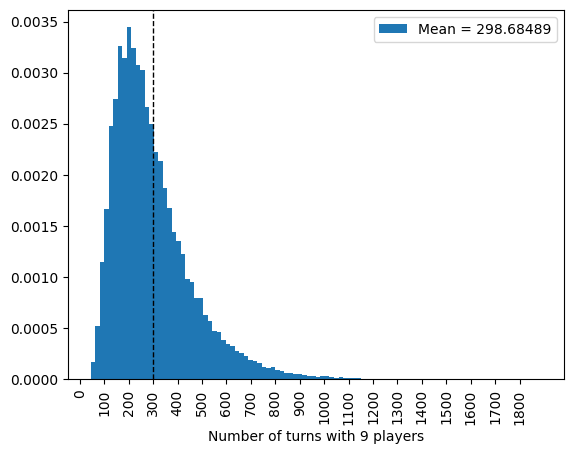

In [62]:
# Some plotting
import matplotlib.pyplot as plt
from statistics import mean
from string import Template

fig_num = 0
for num_players, turns in data.items():
    fig = plt.figure(fig_num)
    plt.hist(turns, density=True, bins=100, label=Template("Mean = $mean_turns").substitute(mean_turns=mean(turns)))
    plt.axvline(mean(turns), color='k', linestyle='dashed', linewidth=1)
    plt.xticks(range(0, max(turns) + 1, 100), rotation='vertical')
    plt.xlabel(Template("Number of turns with $num_players players").substitute(num_players=num_players))
    plt.legend()
    fig_num += 1